In [2]:
import os, import_ipynb
from TVRegression2 import *
from AR2 import *
from ARX2 import *
os.chdir('../../')
from Utils import *

import numpy as np
from scipy.signal import lfilter
import statsmodels.api as sm

importing Jupyter notebook from TVRegression2.ipynb
importing Jupyter notebook from AR2.ipynb
importing Jupyter notebook from ARX2.ipynb
importing Jupyter notebook from Utils.ipynb


In [3]:
'''Human data '''

img_files       = glob('data/1_time_series/gsr/*.csv')
eprime_path     = '/nfs/nfs-davinci/fahad/biobank/data/eprime_files'

idx             = 0
fname           = img_files[0]
subj            = fname.split('/')[-1].split('_')[0].replace('.csv', '')
data            = pd.read_csv(fname, index_col=0)

In [4]:
eprime_fname    = "%s/%s_25748_2_0.txt" % (eprime_path, subj)
frames, ys      = load_frames(eprime_fname, data)

In [ ]:
chunks, corrs, window_ys, window_times\
                = window_timeseries(data, window=10, ys=ys)

ccs, lags, covs = compute_tvfcn_crosscorrs_covs_full(chunks)
rois            = data.columns
results, rels   = get_edge_types(covs, lags, rois, window_ys)

stats, lags2, \
pvals, corrs    = compute_tvfcn_gc(chunks, window=10)

ccs.columns     = lags.columns = covs.columns = stats.columns = \
    lags2.columns = pvals.columns = corrs.columns = window_ys

window_ys       = np.array(window_ys)
edges_pval      = stats.apply(lambda x: ttest_ind(x['Face'], x['Shape'], equal_var=True)[1], axis=1)

In [ ]:
import multiprocessing
import os
  
def fit_sarimax_all_rois(args, order=2):
    #y_t, x_t    = args[:,0], args[1:]
    y_t, x_t = np.array(data[args]), np.array(data.drop(args, axis=1))
    mod_sarimax = sm.tsa.statespace.SARIMAX(y_t, x_t, order=(order,0,0), time_varying_regression=True, mle_regression=False)
    res_sarimax = mod_sarimax.fit(maxiter=500)
    return res_sarimax.states.filtered[order:]

def compute_tvfcn_sarimax_all_rois(data):
    
    #my_list = [np.c_[np.array(data[roi]), np.array(data.drop(roi, axis=1))] for roi in data.columns[:2]]
    my_list = [roi for roi in data.columns[:2]]
    p = multiprocessing.Pool(30)
    
    tvfcn = p.map(fit_sarimax_all_rois, my_list)
    
    return tvfcn

# tvfcn_sarimax = compute_tvfcn_sarimax_all_rois(data)

In [83]:
from hurst import compute_Hc, random_walk

ModuleNotFoundError: No module named 'hurst'

In [84]:
y_t, x_t    = data[data.columns[-1]].values, data[data.columns[:-1]].values
mod_sarimax2 = sm.tsa.statespace.SARIMAX(y_t, x_t, order=(2,0,0))
res_sarimax2 = mod_sarimax.fit(maxiter=500)

In [ ]:
print(res_sarimax2.summary())

In [79]:

y_t, x_t    = data[data.columns[-1]].values, data[data.columns[:-1]].values
mod_sarimax = sm.tsa.statespace.SARIMAX(y_t, x_t, order=(40,0,0), time_varying_regression=True, mle_regression=False)
res_sarimax = mod_sarimax.fit(maxiter=500)
tvfcn = res_sarimax.states.filtered.T[10:]


In [69]:
print(res_sarimax.states.filtered.T.shape)
print(res_sarimax.states.filtered.T[:1].T.shape)
print(res_sarimax.states.filtered.T[1:].shape)

(46, 332)
(332, 1)
(45, 332)


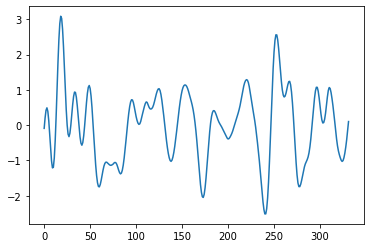

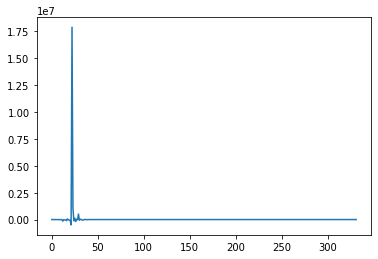

In [80]:
plt.plot(res_sarimax.states.filtered.T[0])
plt.figure()
plt.plot(res_sarimax.states.filtered.T[1]);
# plt.figure()
# plt.imshow(res_sarimax.states.filtered.T[1], aspect='auto')

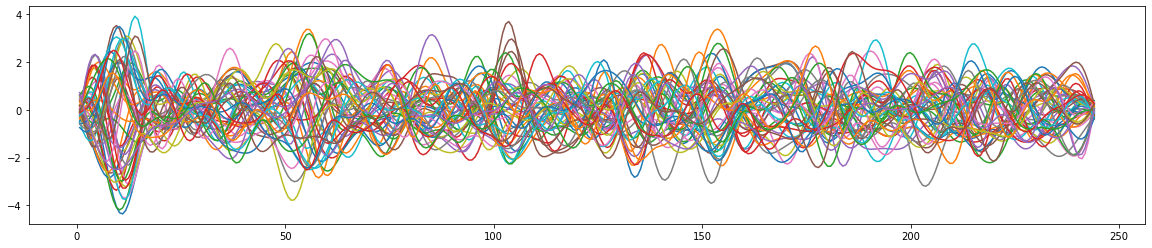

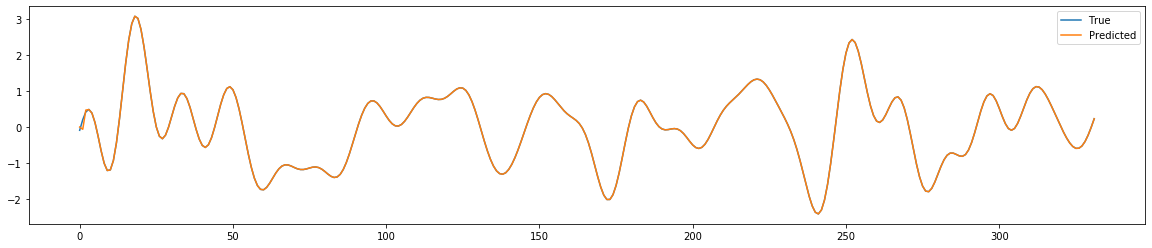

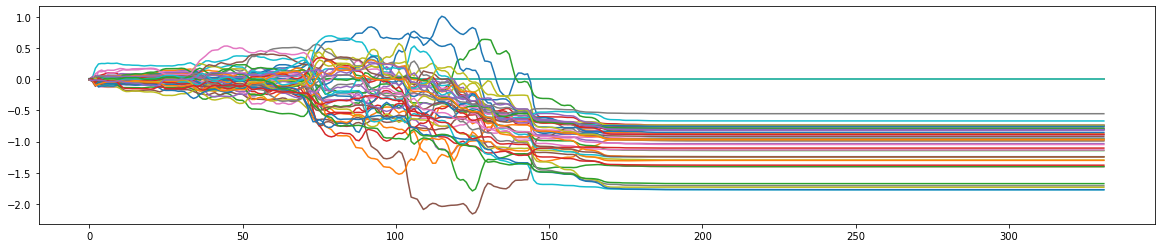

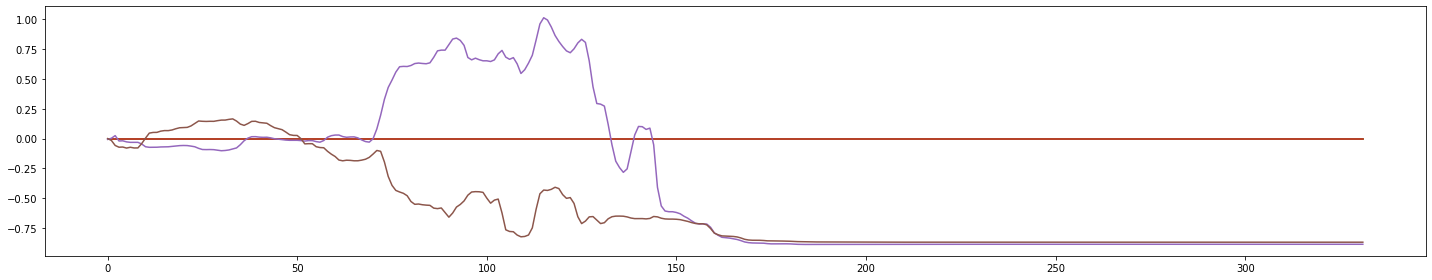

In [23]:
plt.figure(figsize=(20, 4));
plt.plot(data);

plt.figure(figsize=(20, 4))

plt.plot(y_t)
plt.plot(res_sarimax.predict())
plt.legend(['True', 'Predicted'])

plt.figure(figsize=(20, 4))

plt.plot(res_sarimax.states.filtered);

# plt.imshow(res_sarimax.states.filtered.T[:2], aspect='auto', cmap='bwr')
# plt.colorbar()
plt.figure(figsize=(20, 4))
plt.plot(res_sarimax.states.filtered.T[0])
plt.plot(res_sarimax.states.filtered.T[1])
plt.plot(res_sarimax.states.filtered.T[9])
plt.plot(res_sarimax.states.filtered.T[8])
plt.plot(res_sarimax.states.filtered.T[10])
plt.plot(res_sarimax.states.filtered.T[11])
# plt.xticks(range(len(ys)), ys, rotation=90);
plt.tight_layout()

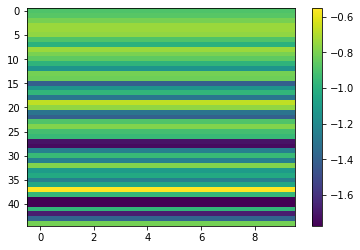

In [45]:
plt.imshow(tvfcn[:,-10:], aspect='auto')
plt.colorbar()

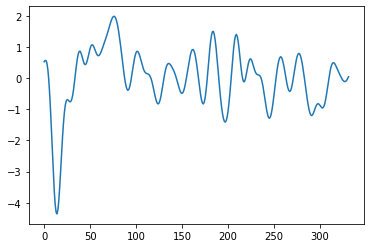

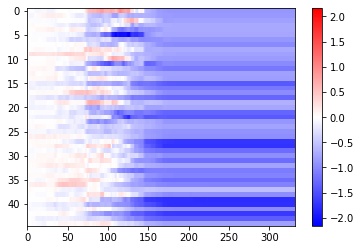

In [33]:
plt.plot(data[data.columns[0]].values)
plt.figure()
vbounds = max(abs(tvfcn.min()), abs(tvfcn.max()))
plt.imshow(tvfcn, aspect='auto', cmap='bwr', vmin=-1*vbounds, vmax=vbounds)
plt.colorbar()

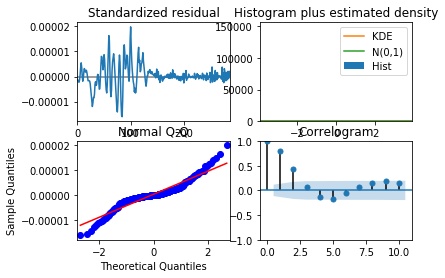

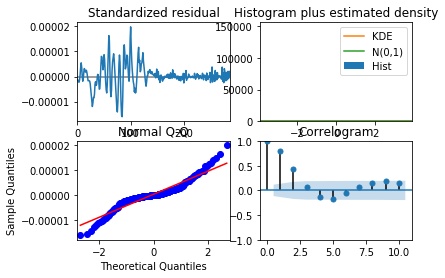

In [87]:
res_sarimax.plot_diagnostics()

In [ ]:
import multiprocessing
import os
  
def fit_sarimax(args):
    y_t, x_t    = args[:,0], args[:,1]
    mod_sarimax = sm.tsa.statespace.SARIMAX(y_t, x_t, order=(2,0,0), time_varying_regression=True, mle_regression=False)
    res_sarimax = mod_sarimax.fit(maxiter=500)
    return res_sarimax.states.filtered[:,-1]

def compute_tvfcn_sarimax(data):
    
    my_list = [np.c_[np.array(data[roi2]), np.array(data[roi1])]\
                for roi1 in data.columns for roi2 in data.columns]
    p = multiprocessing.Pool(30)
    
    tvfcn = p.map(fit_sarimax, my_list)
    
    return tvfcn

tvfcn_sarimax = compute_tvfcn_sarimax(data)

In [12]:
df = pd.DataFrame(tvfcn_sarimax)

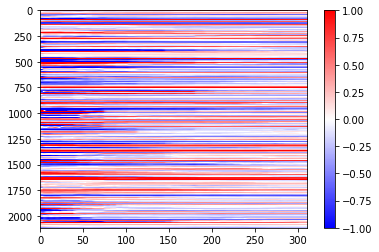

In [30]:
plt.imshow(df[df.columns[20:]], aspect='auto', cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()

In [ ]:
plt.imshow(df, aspect='auto', cmap='bwr', vmin=-5, vmax=5)
plt.colorbar()
plt.figure()
plt.plot(df.iloc[1][20:])

In [3]:
my_list = [np.c_[np.array(data[roi2]), np.array(data[roi1])]\
                for roi1 in data.columns for roi2 in data.columns]

In [7]:
my_list[0][:,0].shape

(332,)

In [ ]:
# def compute_tvfcn_sarimax(data):
#     tvfcn = []
#     for roi1 in data.columns:
#         x_t = np.array(data[roi1])
#         for roi2 in tqdm(data.columns):
#             y_t = np.array(data[roi2])
#             print(x_t.shape, y_t.shape)
#             mod_sarimax = sm.tsa.statespace.SARIMAX(y_t, x_t, order=(2,0,0), time_varying_regression=True, mle_regression=False)
#             res_sarimax = mod_sarimax.fit()
#             tvfcn.append((roi1, roi2, res_sarimax.states.filtered[:,-1]))
#         return tvfcn

# tvfcn_sarimax = compute_tvfcn_sarimax(data)

In [380]:
df = pd.DataFrame([np.append(np.append(row[2], row[0]), row[1])  for row in tvfcn_sarimax])

In [404]:
df = df[df.columns[:-2]].astype(float)

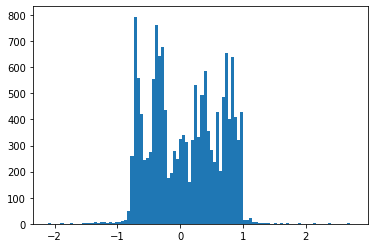

In [412]:
plt.hist(df.values.flatten(), bins=100);

In [ ]:
plt.imshow(df[10:,:], aspect='auto', cmap='bwr', vmin=-2.5, vmax=2.5);
plt.colorbar();

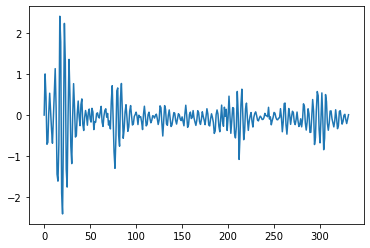

In [303]:
def gen_data_for_model1(nobs=int(1e3), true_phi=np.r_[0.5, -0.2], true_sigma=1**0.5):
    # Simulate a time series
    np.random.seed(1234)
    disturbances = np.random.normal(0, true_sigma, size=(nobs,))
    endog = lfilter([1], np.r_[1, -true_phi], disturbances)
    return endog

def gen_data_for_model2(nobs=1000, d=5, var_y=5, var_coeff_x=0.5):
    rs = np.random.RandomState(seed=93572)

    x_t = rs.uniform(size=nobs)
    eps = rs.normal(scale=var_y**0.5, size=nobs)

    beta_x = np.cumsum(rs.normal(size=nobs, scale=var_coeff_x**0.5))

    y_t = d + beta_x * x_t + eps
    return y_t, x_t, beta_x

def my_own_synthetic_data(x):
    # y_t = a*y_{t-1} + b*y_{t-2} + c_t*x
    rs = np.random.RandomState(seed=93572)
    
    nobs = len(x)
    synthetic = [0, 1]
    a = 0.5
    b = -0.8
    c = rs.normal(loc=0, scale=0.2, size=nobs)
    d = -0.1
    for idx in range(nobs-2):
        synthetic.append((a*synthetic[-1])+(b*synthetic[-2])+(c[idx]*x[idx])+d)
    return synthetic

x = list(data['Frontal Pole'].values)
synthetic = my_own_synthetic_data(x)
plt.plot(synthetic);

In [315]:
# mod_tvr2 = TVRegression2(synthetic, x)
# mod_ar2  = AR2(synthetic)
# mod_arx2 = ARX2(synthetic, x)
mod_sarimax = sm.tsa.statespace.SARIMAX(y_t, x_t, order=(2,0,0), time_varying_regression=True, mle_regression=False)

# res_tvr2 = mod_tvr2.fit()
# res_ar2  = mod_ar2.fit()
# res_arx2 = mod_arx2.fit()
res_sarimax = mod_sarimax.fit()


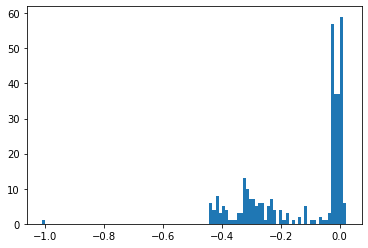

In [325]:
# plt.plot(res_sarimax.states.filtered[:,0])
# plt.plot(res_sarimax.states.filtered[:,1])
# plt.plot(res_sarimax.states.filtered[:,2])
a = plt.hist(res_sarimax.states.filtered[:,2], bins=100)

In [329]:
np.cumsum(a[0]/sum(a[0]))

array([0.00301205, 0.00301205, 0.00301205, 0.00301205, 0.00301205,
       0.00301205, 0.00301205, 0.00301205, 0.00301205, 0.00301205,
       0.00301205, 0.00301205, 0.00301205, 0.00301205, 0.00301205,
       0.00301205, 0.00301205, 0.00301205, 0.00301205, 0.00301205,
       0.00301205, 0.00301205, 0.00301205, 0.00301205, 0.00301205,
       0.00301205, 0.00301205, 0.00301205, 0.00301205, 0.00301205,
       0.00301205, 0.00301205, 0.00301205, 0.00301205, 0.00301205,
       0.00301205, 0.00301205, 0.00301205, 0.00301205, 0.00301205,
       0.00301205, 0.00301205, 0.00301205, 0.00301205, 0.00301205,
       0.00301205, 0.00301205, 0.00301205, 0.00301205, 0.00301205,
       0.00301205, 0.00301205, 0.00301205, 0.00301205, 0.00301205,
       0.02108434, 0.03313253, 0.05722892, 0.06626506, 0.0813253 ,
       0.09337349, 0.09638554, 0.09939759, 0.10240964, 0.11144578,
       0.12048193, 0.15963855, 0.18975904, 0.21084337, 0.23192771,
       0.24698795, 0.26506024, 0.28313253, 0.28614458, 0.30120

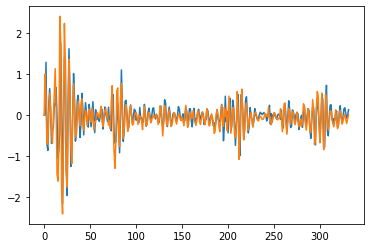

In [312]:
plt.plot(res_sarimax.predict())
plt.plot(synthetic)

In [308]:
print(res_sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  332
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  62.465
Date:                Fri, 11 Jun 2021   AIC                           -116.930
Time:                        18:20:26   BIC                           -101.721
Sample:                             0   HQIC                          -110.864
                                - 332                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5811      0.020     29.311      0.000       0.542       0.620
ar.L2         -0.9324      0.014    -65.241      0.000      -0.960      -0.904
var.x1         0.0155      0.002      9.622      0.0

In [309]:
print(res_sarimax.states.filtered[:,0].mean())
print(res_sarimax.states.filtered[:,1].mean())
print(res_sarimax.states.filtered[:,2].mean())

-0.019533644370756095
0.014409224789898768
-0.03273512268667952


In [74]:
y_t = gen_data_for_model1()

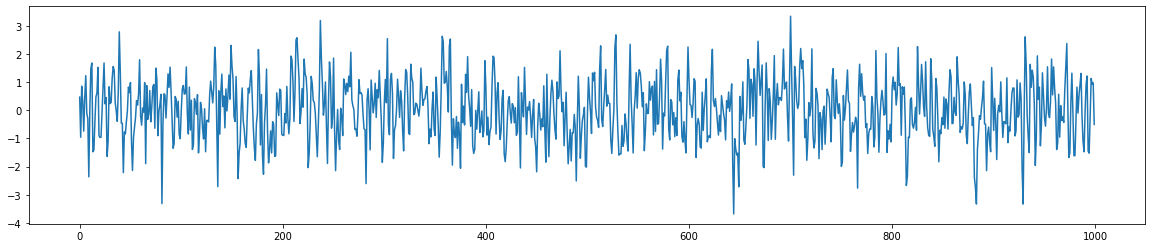

In [76]:
plt.figure(figsize=(20, 4))
plt.plot(y_t)

In [176]:
y_t, x_t, beta_x = gen_data_for_model2()
y_t, x_t = np.array(data['Supramarginal Gyrus']), np.array(data['Hippocampus'])
beta_x = x_t

# _ = plt.plot(y_t)

mod_tvr2 = TVRegression2(y_t, x_t)
mod_ar2  = AR2(y_t)
mod_arx2 = ARX2(y_t, x_t)

res_tvr2 = mod_tvr2.fit()
res_ar2  = mod_ar2.fit()
res_arx2 = mod_arx2.fit()

/home/fahad/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/fahad/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [177]:
window     = 10
a, b = data['Hippocampus'].values, data['Supramarginal Gyrus'].values
corrs_edge = [pearsonr(a[step:step+window], b[step:step+window])[0] for step in range(len(data))\
              if len(a[step:step+window])==window]

In [178]:
from sklearn.preprocessing import normalize

In [210]:
res_arx2.smoothed_state[0]

(332,)

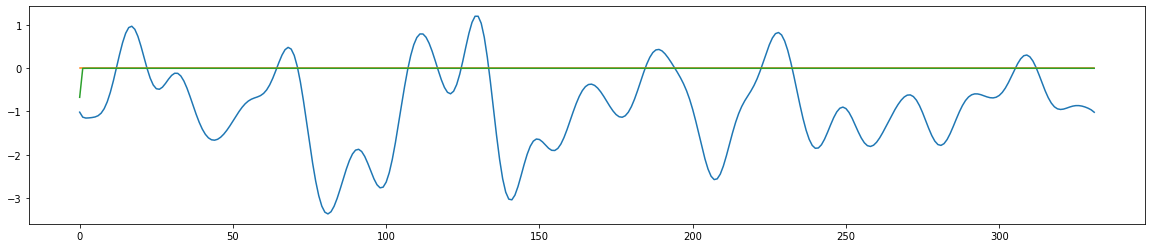

In [213]:
plt.figure(figsize=(20, 4))
# plt.plot(mod_tvr2.ssm.design[0][0])
# plt.plot(mod_arx2.ssm.design[0][0])
# plt.plot(mod_arx2.ssm.design[0][1])
# plt.plot(mod_arx2.ssm.design[0][2])
# plt.plot(y_t)
plt.plot(res_arx2.smoothed_state[0])
plt.plot(res_arx2.smoothed_state[1])
plt.plot(res_arx2.smoothed_state[2])

# plt.plot(res_arx2.states.predicted.T[0])
# plt.plot(res_arx2.states.predicted.T[1])
# plt.plot(res_arx2.states.predicted.T[2])

# plt.plot(corrs_edge)
# plt.plot(list(range(mod.ssm.design.shape[-1])[::10][:-1]), corrs.loc['Hippocampus > Supramarginal Gyrus'].values)
# plt.plot(list(range(mod.ssm.design.shape[-1])[::10][:-1]), \
#         normalize(pvals.loc['Hippocampus > Supramarginal Gyrus'].values.reshape(1, -1))[0])

# plt.plot(list(range(mod.ssm.design.shape[-1])[::10][:-1]), \
#         normalize(stats.loc['Hippocampus > Supramarginal Gyrus'].values.reshape(1, -1))[0])


# plt.plot(list(np.arange(mod.ssm.design.shape[-1])[::10][:-1]+10), \
#         lags.loc['Hippocampus > Supramarginal Gyrus'].values)


# plt.plot(list(np.arange(mod.ssm.design.shape[-1])[::10][:-1]), \
#         ccs.loc['Hippocampus > Supramarginal Gyrus'].values)

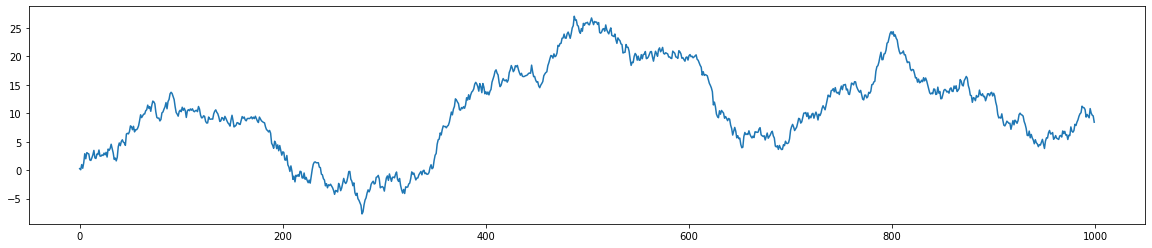

In [56]:
plt.figure(figsize=(20, 4))
    
# plt.plot(np.cumsum(x_t))
rs = np.random.RandomState(seed=93572)
var_coeff_x = 0.5
plt.plot(np.cumsum(rs.normal(size=1000, scale=var_coeff_x**0.5)))
# plt.plot(y_t)
# plt.plot(beta_x)

In [73]:
print(pearsonr(x_t, y_t)), 
print(spearmanr(x_t, y_t)), \
print('\n')
# grangercausalitytests(np.c_[np.roll(y_t, 6), y_t], maxlag=5), \
print(grangercausalitytests(np.c_[y_t, x_t], maxlag=5))

(0.6220423732929309, 3.7403272587235566e-108)
SpearmanrResult(correlation=0.6278010158010159, pvalue=1.022472811909387e-110)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=108.4927, p=0.0000  , df_denom=996, df_num=1
ssr based chi2 test:   chi2=108.8195, p=0.0000  , df=1
likelihood ratio test: chi2=103.2908, p=0.0000  , df=1
parameter F test:         F=108.4927, p=0.0000  , df_denom=996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=63.3766 , p=0.0000  , df_denom=993, df_num=2
ssr based chi2 test:   chi2=127.3914, p=0.0000  , df=2
likelihood ratio test: chi2=119.8927, p=0.0000  , df=2
parameter F test:         F=63.3766 , p=0.0000  , df_denom=993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=45.2597 , p=0.0000  , df_denom=990, df_num=3
ssr based chi2 test:   chi2=136.7390, p=0.0000  , df=3
likelihood ratio test: chi2=128.1400, p=0.0000  , df=3
parameter F test:         F=45.2597 , p=

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                  TVRegression2   Log Likelihood               -2317.153
Date:                Fri, 04 Jun 2021   AIC                           4644.306
Time:                        17:07:21   BIC                           4668.844
Sample:                             0   HQIC                          4653.632
                               - 1000                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       4.8904      0.139     35.089      0.000       4.617       5.164
var.e           4.9949      0.268     18.625      0.000       4.469       5.520
var.x.coeff     0.5634      0.125      4.517    

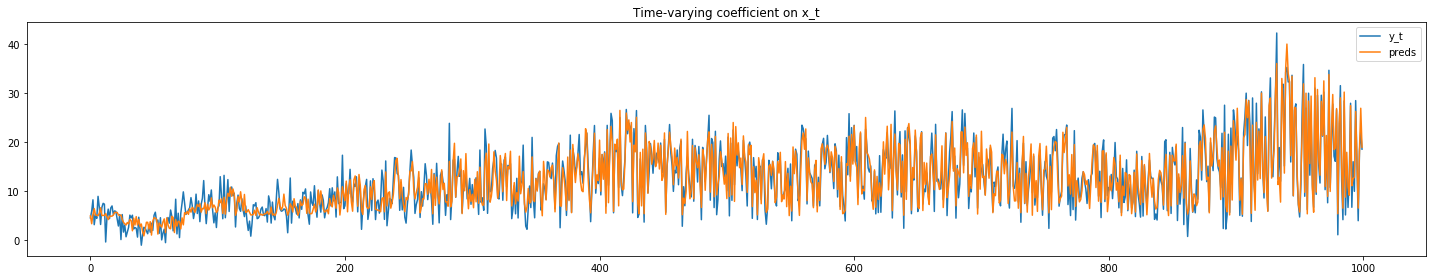

In [14]:
print(res.summary())

fig, axes = plt.subplots(1, figsize=(20, 4))

ss = pd.DataFrame(res.smoothed_state.T, columns=['x'])

# axes.plot(beta_x, label='True')
# axes.plot(ss['x'], label='Smoothed estimate')
axes.plot(y_t, label='y_t')
axes.plot(res.predict(), label='preds')
axes.set(title='Time-varying coefficient on x_t')
axes.legend()

fig.tight_layout()

# AR2

In [117]:
import numpy as np
from scipy.signal import lfilter
import statsmodels.api as sm

# Create and fit the model
mod = AR2(endog)
res = mod.fit()
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                            AR2   Log Likelihood               -1389.437
Date:                Wed, 26 May 2021   AIC                           2784.874
Time:                        17:20:18   BIC                           2799.598
Sample:                             0   HQIC                          2790.470
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
param.0        0.4395      0.030     14.730      0.000       0.381       0.498
param.1       -0.2055      0.032     -6.523      0.000      -0.267      -0.144
param.2        0.9425      0.042     22.413      0.0

# ARX2

/home/fahad/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


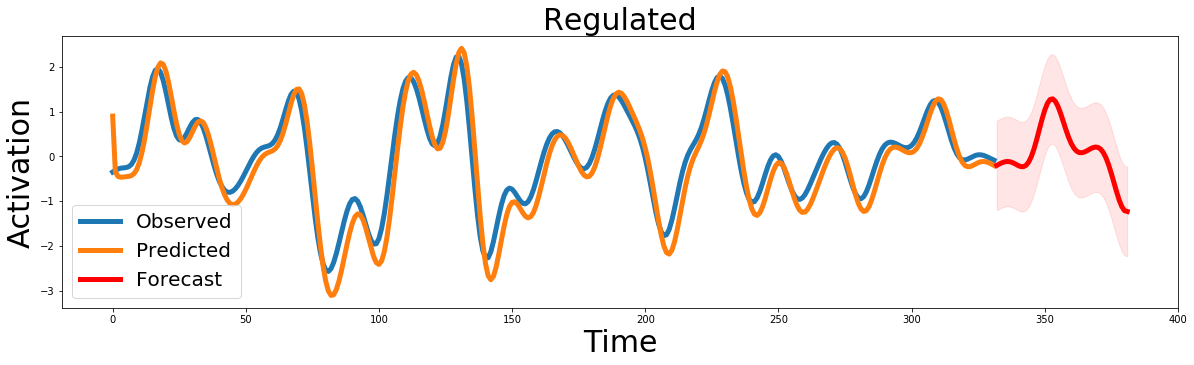

In [94]:
# y_t, x_t, beta_x = gen_data_for_model2()
plt.figure(figsize=(20, 5));
y_t, x_t = np.array(data['Supramarginal Gyrus']), np.array(data['Hippocampus'])
beta_x = x_t

mod = ARX2(y_t, x_t)
res = mod.fit(maxiter=500)

plt.plot(y_t, linewidth=5);
plt.plot(res.predict(), linewidth=5);
plt.plot(range(len(y_t), len(y_t)+50), res.predict()[::-1][:50], color='red', linewidth=5);
plt.fill_between(range(len(y_t), len(y_t)+50), res.predict()[::-1][:50]-1, res.predict()[::-1][:50]+1, alpha=0.1, color='red')
plt.xlabel('Time', fontsize=30);
plt.ylabel('Activation', fontsize=30);
# plt.figure();
plt.legend(['Observed', 'Predicted', 'Forecast'], fontsize=20, loc='lower left')
plt.title('Regulated', fontsize=30);
plt.savefig('out/predictions.png')
# plt.plot(res.smoothed_state[0]);
# plt.plot(res.smoothed_state[1]);
# plt.plot(res.smoothed_state[2]);

# print(res.summary())

/home/fahad/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(-3, 6)

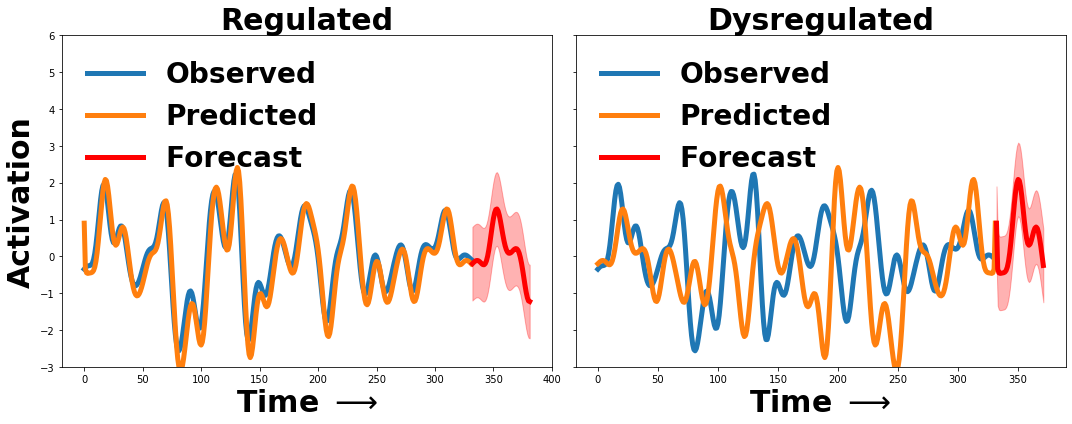

In [212]:

# fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True, gridspec_kw={'width_ratios': [1.5, 2.2]});
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True, gridspec_kw={'width_ratios': [1, 1]});
y_t, x_t = np.array(data['Supramarginal Gyrus']), np.array(data['Hippocampus'])
beta_x = x_t

mod = ARX2(y_t, x_t)
res = mod.fit(maxiter=500)

axs[0].plot(y_t, linewidth=5);
axs[0].plot(res.predict(), linewidth=5);
axs[0].plot(range(len(y_t), len(y_t)+50), res.predict()[::-1][:50], color='red', linewidth=5);
axs[0].fill_between(range(len(y_t), len(y_t)+50), res.predict()[::-1][:50]-1, res.predict()[::-1][:50]+1, alpha=0.3, color='red')
axs[0].set_xlabel(r'Time $\longrightarrow$', fontsize=30, fontweight='bold');
axs[0].set_ylabel('Activation', fontsize=30, fontweight='bold');
# plt.figure();
# axs[0].legend(['Observed', 'Predicted', 'Forecast'], fontsize=30, loc='upper left', bbox_to_anchor=(1.01, 1))
axs[0].legend(['Observed', 'Predicted', 'Forecast'], fontsize=30, loc='upper left', frameon=False, prop={'weight':'bold', 'size':28})
axs[0].set_title('Regulated', fontsize=30, fontweight='bold');


# plt.plot(y_t+np.random.normal(0, 1.5, len(y_t)), linewidth=5);
noise = np.concatenate([np.zeros(int(len(y_t)/3)), 0*np.ones(int(len(y_t)/3)), 0*np.ones(int(len(y_t)/3)), [0, 0]])
# noise = np.concatenate([np.zeros(int(len(y_t)/2)), np.random.uniform(-1, 1, int(len(y_t)/2))])
axs[1].plot((y_t+noise), linewidth=5);
a = res.predict()[::-1]
axs[1].plot(a, linewidth=5);
b = a[-40:]
axs[1].plot(range(len(y_t), len(y_t)+40), b[::-1], color='red', linewidth=5);
axs[1].fill_between(range(len(y_t), len(y_t)+40), b[::-1]-1, b[::-1]+1, alpha=0.3, color='red')
axs[1].set_xlabel(r'Time $\longrightarrow$', fontsize=30, fontweight='bold');
# axs[1].set_ylabel('Activation', fontsize=30);
axs[1].legend(['Observed', 'Predicted', 'Forecast'], fontsize=30, loc='upper left', frameon=False, prop={'weight':'bold', 'size':28})#, bbox_to_anchor=(1.01, 1))
axs[1].set_title('Dysregulated', fontsize=30, fontweight='bold')
plt.tight_layout()
plt.savefig('out/predictions.png')
# plt.plot(res.smoothed_state[0]);
# plt.plot(res.smoothed_state[1]);
# plt.plot(res.smoothed_state[2]);

plt.ylim(-3, 6)

# print(res.summary())

In [507]:
predict = res.get_prediction()

In [462]:
np.c_[x_t[-10:]].T.shape, np.c_[x_t[-10:]].shape, y_t[-10:].shape

((1, 10), (10, 1), (10,))

In [ ]:
res.get_forecast(steps=10, endog=np.c_[y_t[-10:]], exog=np.c_[x_t[-10:]])

In [319]:
# import requests
# from io import BytesIO 

# friedman2 = requests.get('https://www.stata-press.com/data/r12/friedman2.dta').content
# data = pd.read_stata(BytesIO(friedman2))
# data.index = data.time
# data.index.freq = "QS-OCT"

# # Variables
# endog = data.loc['1959':'1981', 'consump']
# # exog = sm.add_constant(data.loc['1959':'1981', 'm2'])
# exog = data.loc['1959':'1981', 'm2']
# # exog.columns = ['syed', 'fahad']

# # Fit the model
# mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(2,0,0), time_varying_regression=True, mle_regression=False)
# res = mod.fit(disp=False)
# print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  332
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 578.254
Date:                Fri, 04 Jun 2021   AIC                          -1148.509
Time:                        19:40:39   BIC                          -1133.300
Sample:                             0   HQIC                         -1142.443
                                - 332                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9369      0.011    176.290      0.000       1.915       1.958
ar.L2         -0.9744      0.011    -92.253      0.000      -0.995      -0.954
var.x1      3.214e-10   3.64e-05   8.83e-06      1.0

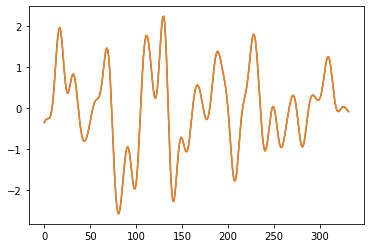

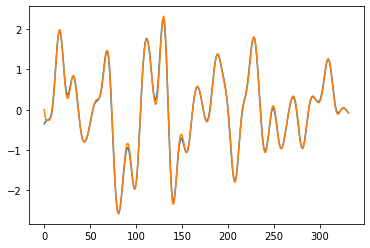

In [217]:
y_t, x_t = np.array(data['Supramarginal Gyrus']), np.array(data['Hippocampus'])
beta_x = x_t

mod = sm.tsa.statespace.SARIMAX(endog=y_t, exog=x_t, order=(2,0,0), time_varying_regression=True, mle_regression=False)
res = mod.fit(disp=False)
print(res.summary())

plt.plot(y_t)
plt.plot(res.smoothed_state[0]);
# plt.plot(res.smoothed_state[1]);
# plt.plot(res.smoothed_state[2]);

plt.figure()
plt.plot(y_t);
plt.plot(res.predict());

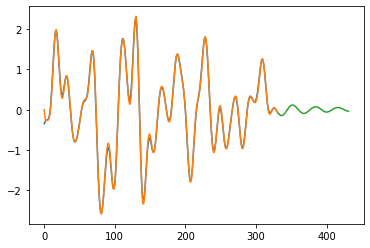

In [491]:
plt.plot(y_t);
plt.plot(res.predict());
plt.plot(range(len(y_t), len(y_t)+100), res.forecast(steps=100, exog=y_t[-100:]))

In [8]:
# mod2 = sm.tsa.statespace.SARIMAX(endog=y_t, exog=x_t, order=(2,0,0), time_varying_regression=True, mle_regression=False)
# print(mod.param_names)
# print(mod.ssm.transition)
# print(mod.ssm.design.shape)
# print(mod.ssm.design)

In [385]:
np.equal(mod.ssm.design, mod2.ssm.design).sum(), mod2.ssm.design.shape

(996, (1, 3, 332))

In [391]:
np.equal(mod.ssm.design[:,2,:], mod2.ssm.design[:,2,:]).sum()

332

In [392]:
np.all(mod.ssm.design[:,2,:]==x_t)

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      